In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")
import pandas as pd
import numpy as np

from matplotlib import style
import seaborn as sns

from src.evaluate_model import report_metrics, weighted_absolute_percentage_error, r2_score_adjusted
from src.regression_model import MMMRegression
from sklearn.linear_model import Ridge
from src.utils.plots import plot_prediction, plot_weights
from src.optimize_hyperparams import optimize_linear_regression

pd.options.display.float_format = '{:.4f}'.format
sns.set_theme()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option("display.max_columns", 6)

sns.set_theme()

/Users/marianebando/Library/Caches/pypoetry/virtualenvs/projeto-ifood-3w4bfTek-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problema Case Ifood
> Objetivo: Entender o impacto dos investimentos em mídia nos indicadores de desempenho (tráfego e engajamento do usuário) e fornecer recomendações estratégicas para otimizar o gasto com mídia.


> Desafio: Identificar quais canais de mídia estão impulsionando os KPIs e como otimizar o orçamento de mídia.

## Import data

De acordo com as instruções do case, as colunas do arquivo representam:
- mo­no­to­ni­cid: Iden­ti­fi­ca­dor úni­co para cada re­gis­tro.
- date: Data do re­gis­tro.
- traf­fic: Nú­me­ro de vi­si­tas ao site.
- no­ti­fi­ca­ti­ons­sent: Nú­me­ro de no­ti­fi­ca­ções en­vi­a­das.
- no­ti­fi­ca­ti­ons­clic­ked: Nú­me­ro de no­ti­fi­ca­ções que fo­ram cli­ca­das.
- nac­ti­veu­sers: Nú­me­ro de usuá­ri­os ati­vos.
- event1 e event2: in­di­ca­dor bo­o­le­a­no, re­la­ci­o­na­das ao acon­te­ci­men­to de eventos es­pe­cí­fi­cos.
- Co­lu­nas de in­ves­ti­men­to em mí­dia: cine­ma, digi­tal, in­flu, news­pa­pers, of­fli­ne, ra­dio, so­ci­al, tv, other­me­di­as.
- ho­li­day: In­di­ca­dor se o dia é fe­ri­a­do. 

In [2]:
from src.prepare_data import load_data, agg_by_week
df = load_data('/Users/marianebando/Documents/Git/projeto_ifood')
df_week = agg_by_week(df)
df_week.head()

,weeks_from_start,date,traffic,...,month,week_of_month,has_media_investment
0,1,2007-01-15,567597,...,2007-01,2,False
1,2,2007-01-22,560370,...,2007-01,3,False
2,3,2007-01-29,568526,...,2007-01,4,False
3,4,2007-02-05,600621,...,2007-02,1,False
4,5,2007-02-12,597438,...,2007-02,2,False


In [3]:
from src.utils.seasonality_effect import get_seasonality
degree = 2
period_year = 52

df_season_year = get_seasonality(df_week["date"], period = period_year, degree = degree)
df_season_year.columns = ["year_" + col for col in df_season_year.columns]
df_week = pd.concat([df_week, df_season_year], axis =1)

In [4]:
df_train, df_test = train_test_split(df_week, test_size = 0.20, random_state = 42, shuffle=False) # shuffle False to keep the order
print(f"Train set from week {int(df_train.index.min())} to {int(df_train.index.max())}")
print(f"Test set from week {int(df_test.index.min())} to {int(df_test.index.max())}")

Train set from week 0 to 52
Test set from week 53 to 66


# 1. Set Features and Params

In [5]:
medias = ["cinema","digital","influ","newpapers","offline","radio","social","tv","other_medias"]
medias_with_more_investment = ["tv", "other_medias", "digital", "offline", "influ", "social"]

scale_features = ["notifications_sent"]
normalize_features = ["n_active_users", "holiday", "week_of_month"]



# 2. Ridge

O Ridge Regression é frequentemente preferido à Regressão Linear em casos de multicolinearidade porque ele adiciona um termo de regularização que ajuda a estabilizar as estimativas dos coeficientes, tornando o modelo mais robusto. 


Na Regressão Linear sem regularização, a multicolinearidade pode causar coeficientes instáveis, ou seja, pequenas variações nos dados podem levar a grandes mudanças nos coeficientes estimados. Isso resulta em um modelo sensível ao ruído e com baixa capacidade de generalização.


Ao aplicar a penalidade, o Ridge controla o problema de multicolinearidade, produzindo coeficientes mais estáveis e menos sensíveis ao ruído nos dados. O modelo resultante tende a generalizar melhor para novos dados.

## 2.1 Ridge sem restrições

In [6]:
# use normal Ridge regression
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"] + df_season_year.columns.tolist()
ridge_with_no_constraints = Ridge(alpha = 1)
ridge_with_no_constraints.fit(df_train[all_features], df_train["traffic"])
pred_ridge_with_no_constraints = ridge_with_no_constraints.predict(df_test[all_features])
report_metrics(df_test["traffic"], pred_ridge_with_no_constraints)

Metric    Value
--------  ----------
mae       R$ 27.9mil
mape      3.8%
wape      3.8%
r2        -9.5%


Sem as variáveis sazonais (série de fourier), o modelo tem métricas melhores. Possivelmente a sazonalidade está confundindo-o.

In [7]:
# use normal Ridge regression
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"]
ridge_with_no_constraints = Ridge(alpha = 1)
ridge_with_no_constraints.fit(df_train[all_features], df_train["traffic"])
pred_ridge_with_no_constraints = ridge_with_no_constraints.predict(df_test[all_features])
report_metrics(df_test["traffic"], pred_ridge_with_no_constraints)

Metric    Value
--------  ----------
mae       R$ 30.5mil
mape      4.2%
wape      4.2%
r2        -7.0%


## 2.2 Ridge com restrições

### Teste da Ridge com efeitos simples: Adstock geométrico e Saturação logística: melhor

In [8]:
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"] 

best_params = {"regression__alpha":0.2}
ridge_model = MMMRegression(
    medias=medias_with_more_investment, 
    model_type="ridge",
    positive_features=medias_with_more_investment+["event1", "event2"], 
    # biased_features=["n_active_users"],
    # confounders=all_features,
    normalize_features=normalize_features+medias_with_more_investment,
    scale_features=scale_features,
    all_features = all_features,
    best_params=best_params, 
    )
ridge_model.fit(df_train[all_features], df_train["traffic"])

pred_ridge_train = ridge_model.predict(df_train[all_features])
pred_ridge_test = ridge_model.predict(df_test[all_features])

print("Test")
print(ridge_model.score(df_test["traffic"], pred_ridge_test))

Test
Metric    Value
--------  ----------
mae       R$ 34.0mil
mape      4.7%
wape      4.6%
r2        -44.8%
None


No gráfico abaixo, é possível ver a diferença entre o dado "raw" e o dado com o adstock + sazonalidade - essa última força o intervalo entre 0 e 1.

<Axes: >

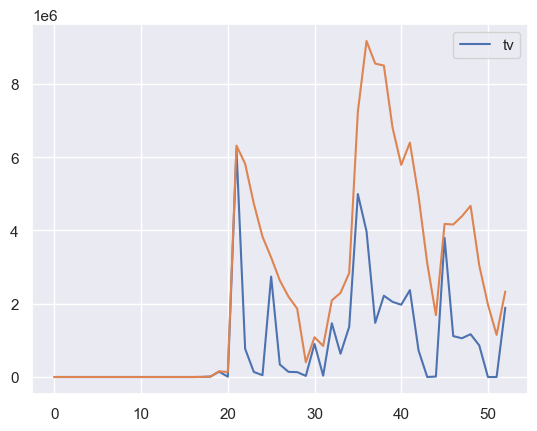

In [10]:
# apply adstock transformation to the media variables
df_train_transformed = ridge_model.model["adstock"].transform(df_train)
df_train_transformed = ridge_model.model["to_df1"].transform(df_train_transformed)
# plot both original and transformed variable
df_train[["tv"]].plot(alpha = 1)
df_train_transformed["tv"].plot(secondary_y=False)

<Axes: >

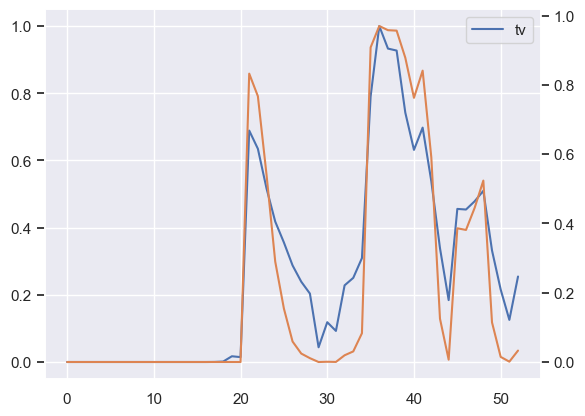

In [12]:
# apply adstock transformation to the media variables
df_train_saturation = ridge_model.model["saturation"].transform(df_train_transformed)
df_train_saturation = ridge_model.model["to_df3"].transform(df_train_saturation)
# # plot both original and transformed variable
df_train_transformed[["tv"]].plot(alpha = 1)
df_train_saturation["tv"].plot(secondary_y=True)

#### Otimizando Ridge

In [13]:
tuned_model = optimize_linear_regression(
    ridge_model.model, 
    X = df_train[all_features], 
    y = df_train["traffic"], 
    medias = medias_with_more_investment, 
    n_trials=500,
    scorer="r2", 
    # scorer=weighted_absolute_percentage_error,
    dump=True,
    dir = "/Users/marianebando/Documents/Git/projeto_ifood/models"
    )

[I 2024-08-18 20:45:24,690] A new study created in memory with name: no-name-975d456e-bafe-41d1-90cd-e632990a75f4
[I 2024-08-18 20:45:25,552] Trial 1 finished with value: -4.458107525933927 and parameters: {'adstock__tv_pipe__carryover__func': 'delayed', 'adstock__tv_pipe__carryover__decay_factor': 0.4601233818019126, 'adstock__tv_pipe__carryover__L': 3, 'adstock__tv_pipe__carryover__theta': 2, 'saturation__tv_pipe__saturation__function_curve': 'hill', 'saturation__tv_pipe__saturation__midpoint': 0.7754333962824218, 'saturation__tv_pipe__saturation__slope_s': 2.075559031053583, 'regression__alpha': 0.5298820425545472, 'adstock__other_medias_pipe__carryover__func': 'delayed', 'adstock__other_medias_pipe__carryover__decay_factor': 0.6293502932998755, 'adstock__other_medias_pipe__carryover__L': 6, 'adstock__other_medias_pipe__carryover__theta': 3, 'saturation__other_medias_pipe__saturation__function_curve': 'hill', 'saturation__other_medias_pipe__saturation__midpoint': 0.3382578561892915,

Melhores parâmetros encontrados:  {'adstock__tv_pipe__carryover__func': 'delayed', 'adstock__tv_pipe__carryover__decay_factor': 0.7858565971350063, 'adstock__tv_pipe__carryover__L': 7, 'adstock__tv_pipe__carryover__theta': 0, 'saturation__tv_pipe__saturation__function_curve': 'hill', 'saturation__tv_pipe__saturation__midpoint': 0.4091760234023252, 'saturation__tv_pipe__saturation__slope_s': 8.196357487022635, 'regression__alpha': 0.20020612004473862, 'adstock__other_medias_pipe__carryover__func': 'delayed', 'adstock__other_medias_pipe__carryover__decay_factor': 0.345349238966854, 'adstock__other_medias_pipe__carryover__L': 3, 'adstock__other_medias_pipe__carryover__theta': 0, 'saturation__other_medias_pipe__saturation__function_curve': 'hill', 'saturation__other_medias_pipe__saturation__midpoint': 0.3402353784763567, 'saturation__other_medias_pipe__saturation__slope_s': 2.5512252586376847, 'adstock__digital_pipe__carryover__func': 'delayed', 'adstock__digital_pipe__carryover__decay_fac

In [12]:
# from glob import glob
# import json
# last_file = sorted(
#     list(glob("/Users/marianebando/Documents/Git/projeto_ifood/models/hyperparams_calibration_*.json")), reverse=True
# )[0]
# with open(last_file, "r") as f:
#     best_params = json.load(f)["best_params"]

Train
Metric    Value
--------  ----------
mae       R$ 17.1mil
mape      2.6%
wape      2.6%
r2        73.2%
None
Test
Metric    Value
--------  ----------
mae       R$ 35.8mil
mape      5.0%
wape      4.9%
r2        -52.8%
None


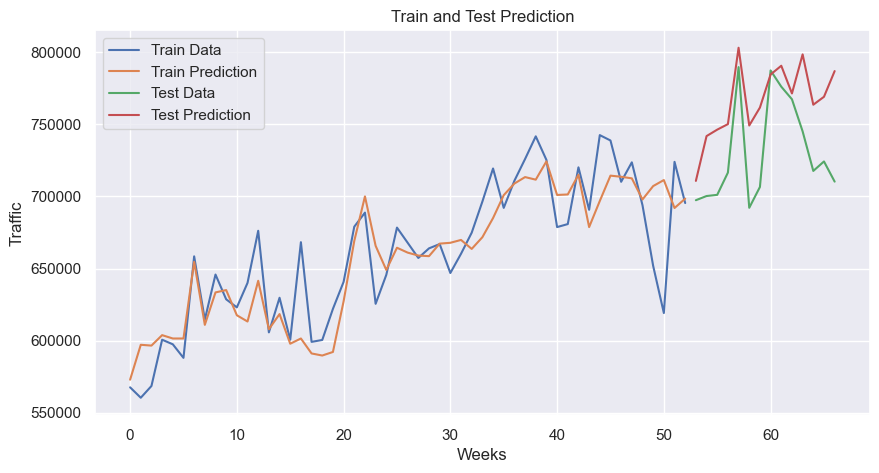

In [14]:
best_params = tuned_model.best_params_

all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"] 
ridge_model = MMMRegression(
    medias=medias_with_more_investment, 
    model_type="ridge", 
    positive_features=medias_with_more_investment+["event1", "event2"], 
    all_features = all_features, 
    normalize_features=normalize_features+medias_with_more_investment,
    scale_features=scale_features,
    best_params=best_params
    )
ridge_model.fit(df_train[all_features], df_train["traffic"])

pred_ridge_train = ridge_model.predict(df_train[all_features])
pred_ridge_test = ridge_model.predict(df_test[all_features])
print("Train")
print(ridge_model.score(df_train["traffic"], pred_ridge_train))
print("Test")   
print(ridge_model.score(df_test["traffic"], pred_ridge_test))

plot_prediction(df_train["traffic"], df_test["traffic"], pred_ridge_train, pred_ridge_test, fig_size=(10,5))

In [15]:
# get coefficients from ridge_model.model.named_steps["regression"].coef_
weights = {col: float(coef) for col, coef in zip(all_features, ridge_model.model.named_steps["regression"].coef_)}
weights = pd.Series(weights).sort_values(ascending=False)
weights

notifications_sent   86049.8560
holiday              53160.6874
tv                   36630.9022
other_medias         30558.9153
event2               19049.0480
n_active_users        7194.8409
influ                 5084.4358
offline               3172.3614
week_of_month            0.0000
digital                 -0.0000
social                  -0.0000
event1                  -0.0000
dtype: float64

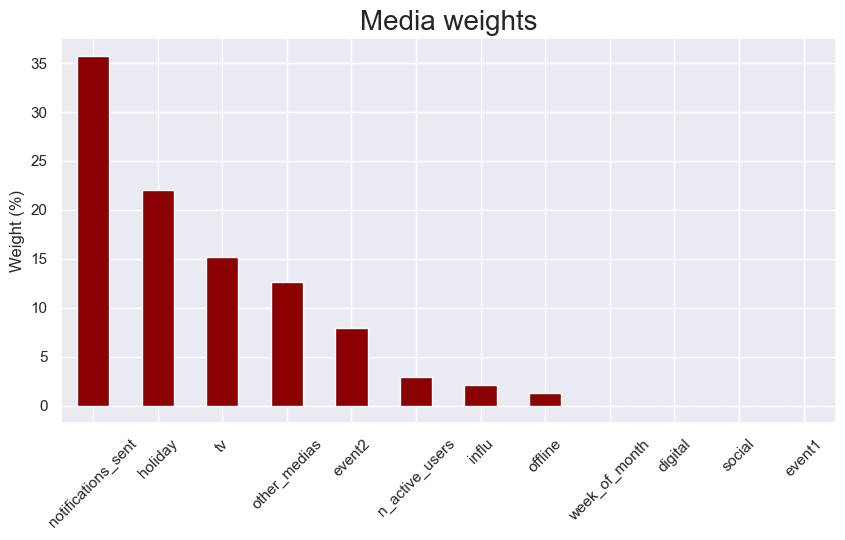

In [16]:
plot_weights(weights/weights.sum()*100, figsize=(10, 5))

In [17]:
weighted_weights = (weights[medias_with_more_investment]/weights[medias_with_more_investment].sum()).sort_values(ascending=False)
weighted_weights

tv              0.4855
other_medias    0.4050
influ           0.0674
offline         0.0420
digital        -0.0000
social         -0.0000
dtype: float64

# Simulando investimento

In [22]:
df_new_media = {}
weeks = 15
investment = 10_000_000
# investment = 200
for media in weighted_weights[weighted_weights>0].index:
    df_new = pd.DataFrame({col: np.zeros(weeks) for col in all_features})
    df_new["n_active_users"] = df_week["n_active_users"].iloc[-1]
    df_new["notifications_sent"] = df_week["notifications_sent"].iloc[-1]
    df_new["week_of_month"] = 2
    df_new[media].iloc[5] = investment
    df_new["pred"] = ridge_model.predict(df_new[all_features])
    total_added_traffic = round(df_new["pred"] - df_new["pred"].iloc[0]).sum()
    print(f'Investment in {media} was: R${investment/1e6}MM and return in traffic was {round(total_added_traffic)} ({total_added_traffic/investment}/real invested)')
    
    df_new_media[media] = df_new

Investment in tv was: R$10.0MM and return in traffic was 94691 (0.0094691/real invested)
Investment in other_medias was: R$10.0MM and return in traffic was 60844 (0.0060844/real invested)
Investment in influ was: R$10.0MM and return in traffic was 16985 (0.0016985/real invested)
Investment in offline was: R$10.0MM and return in traffic was 9529 (0.0009529/real invested)


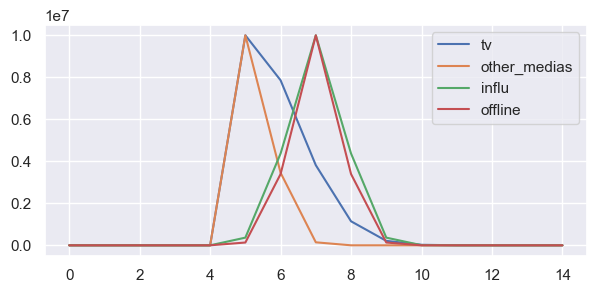

In [23]:
from matplotlib import pyplot as plt
pd.options.display.max_columns = None
fig = plt.figure(figsize=(7,3))
# apply adstock transformation to the media variables
# see all pandas columns
df_new_media2 = df_new_media
for media in weighted_weights[weighted_weights>0].index:
    df_new_media2[media] = ridge_model.model["adstock"].transform(df_new_media2[media])
    df_new_media2[media] = ridge_model.model["to_df1"].transform(df_new_media2[media])
    df_new_media2[media][media].plot(label = media)
plt.legend()

In [24]:
for media in weighted_weights[weighted_weights>0].index:
    df_new_media2[media] = ridge_model.model["preprocessor"].transform(df_new_media2[media])
    df_new_media2[media] = ridge_model.model["to_df2"].transform(df_new_media2[media])
df_new_media2["tv"]["tv"]

0    0.0000
1    0.0000
2    0.0000
3    0.0000
4    0.0000
5    1.1728
6    0.9216
7    0.4473
8    0.1341
9    0.0248
10   0.0028
11   0.0002
12   0.0000
13   0.0000
14   0.0000
Name: tv, dtype: float64

In [25]:
# r = np.arange(0, 2_000_000, 10000)
return_media = {}
weeks = 15
investment = 1_000_000
for media in weighted_weights[weighted_weights>0].index:
    return_by_value = {}
    for investment in range(100_000, 5_000_000, 200_000):
        df_new = pd.DataFrame({col: np.zeros(weeks) for col in all_features})
        df_new["n_active_users"] = df_week["n_active_users"].iloc[-1]
        df_new["notifications_sent"] = df_week["notifications_sent"].iloc[-1]
        df_new["week_of_month"] = 2
        df_new[media].iloc[5] = investment
        df_new["pred"] = ridge_model.predict(df_new[all_features])
        total_added_traffic = round(df_new["pred"] - df_new["pred"].iloc[0]).sum()
        return_by_value[investment] = total_added_traffic/investment
    return_media[media] = return_by_value

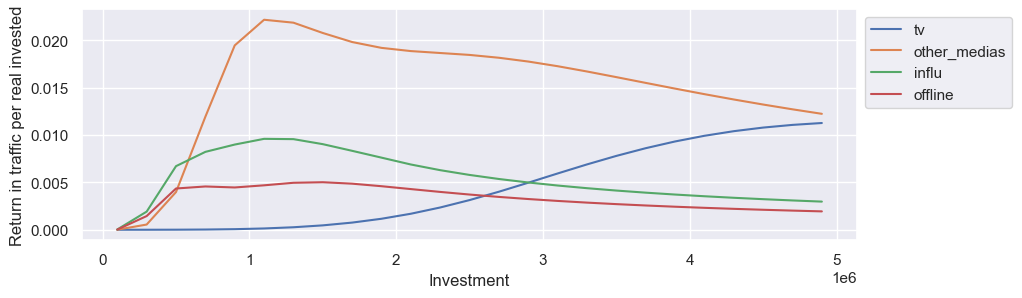

In [35]:
# plot return_media["other_medias"]
fig = plt.figure(figsize=(10,3))
for media in weighted_weights[weighted_weights>0].index:
    pd.Series(return_media[media]).plot(label = str(media))
plt.ylabel("Return in traffic per real invested")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("Investment")
plt.show()